## Yield prediction

In the world of fixed income, trying to predict the nature of yield curves is of critical importance. Not only are most of the instruments used to create the yield curve. It is also used to pricing numerous derivatives on top of it. The Dynamics of the yield curve and all the modelling approaches are beyond the scope of this case study. We will focus our attention on the predictability of the yield curve.

This case study wwas inspired by the paper Nunes, Gerding, McGroarty and Niranjan (2018) https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3144622

### Python Imports

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

C:\Users\sahil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Prediction Variables

Unlike previous case studies, we attempt to predict multiple output variables. In this case study we try to predict the changes in the 1 month, 5 year and 30 year yield curve data points.

### Feature Variables

In order to make predictions, we use the following features -


    1. Previous Changes in the Treasury Curve at the following data points
        
        a. 1 Month
        
        b. 3 Month
        
        c. 1 Year
        
        d. 2 Year
        
        e. 5 Year
        
        f. 7 Year
        
        g. 10 Year
        
        h. 30 Year
        
    2. Changes in % of Federal Debt held by -
    
        a. Public
        
        b. Foreign Goverments
        
        c. Federal Reserve
        
    3. The Coporate Spread on Baa rated Debt Relative to the 10 Year

In [2]:
# Get the data by webscapping using pandas datareader
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]
tsy_data = web.DataReader(tsy_tickers, 'fred').dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [3]:
return_period = 5
Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].diff(return_period).shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']].diff(return_period)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

### Data Exploration

In [4]:
dataset.shape

(484, 15)

In [5]:
pd.set_option('precision', 3)
dataset.describe()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
count,484.000,484.000,484.000,484.000,484.000,484.000,484.000,484.000,484.000,484.000,484.000,4.840e+02,4.840e+02,4.840e+02,4.840e+02
mean,0.004,-0.002,-0.005,0.004,0.004,0.003,0.001,-0.002,-0.004,-0.004,-0.005,6.954e-05,1.801e-04,-2.010e-05,-5.165e-04
std,0.043,0.103,0.104,0.043,0.031,0.040,0.063,0.103,0.110,0.106,0.104,7.872e-04,1.179e-03,1.593e-03,5.773e-02
min,-0.310,-0.320,-0.390,-0.310,-0.120,-0.240,-0.260,-0.320,-0.320,-0.370,-0.390,-5.531e-03,-5.315e-03,-1.384e-02,-2.200e-01
25%,-0.010,-0.060,-0.070,-0.010,-0.010,-0.010,-0.030,-0.060,-0.070,-0.070,-0.070,-2.252e-06,0.000e+00,0.000e+00,-4.000e-02
50%,0.000,-0.010,-0.010,0.000,0.000,0.000,0.000,-0.010,-0.010,-0.010,-0.010,3.454e-06,0.000e+00,0.000e+00,0.000e+00
75%,0.020,0.060,0.060,0.020,0.020,0.020,0.030,0.060,0.060,0.060,0.060,3.290e-04,0.000e+00,0.000e+00,3.000e-02
max,0.310,0.420,0.430,0.310,0.190,0.200,0.250,0.420,0.460,0.440,0.430,3.247e-03,1.128e-02,1.299e-02,2.700e-01


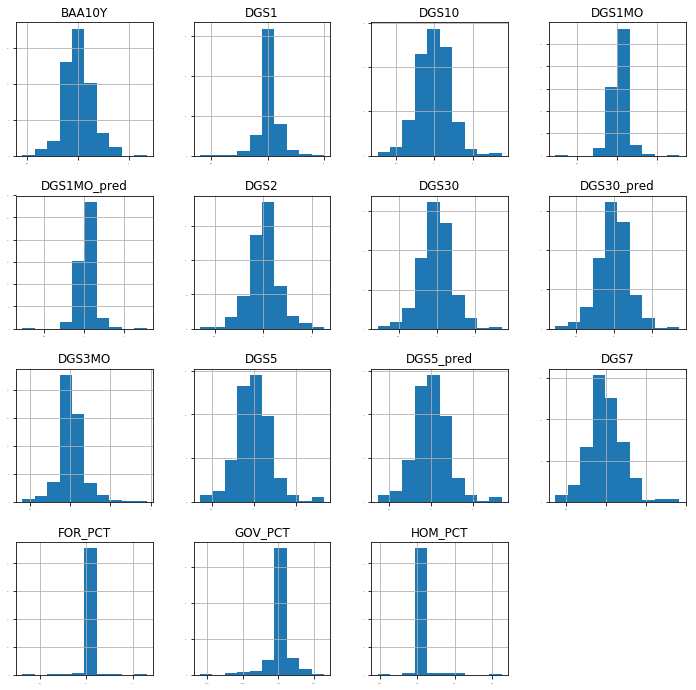

In [6]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

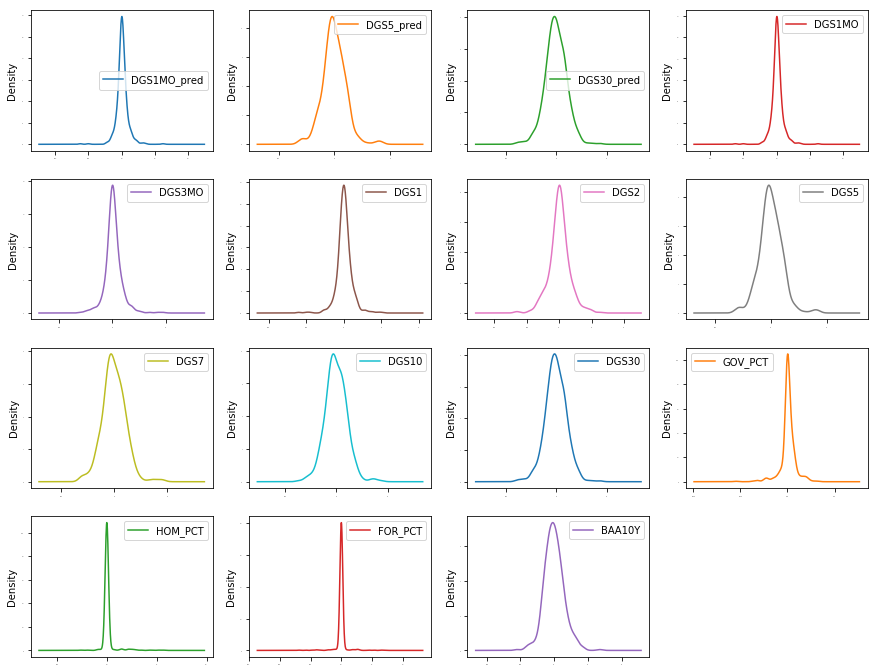

In [7]:
# density
dataset.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

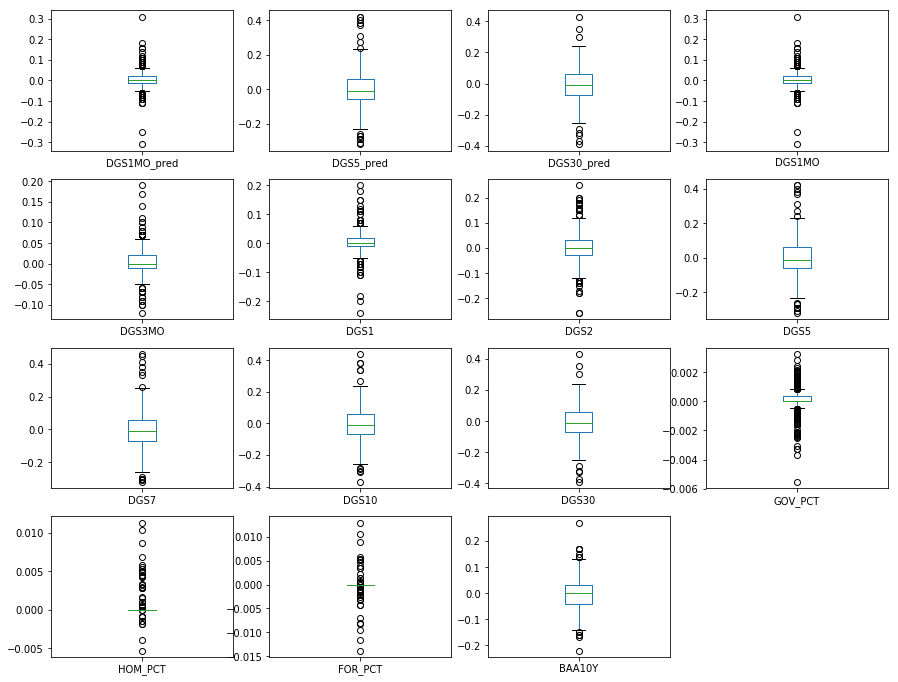

In [8]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

We observe the that % debt held by various agencies is relatively fat tailed. We observe a normal like distribution in the other features and prediction variables.

Next We look at the interaction between these variables.

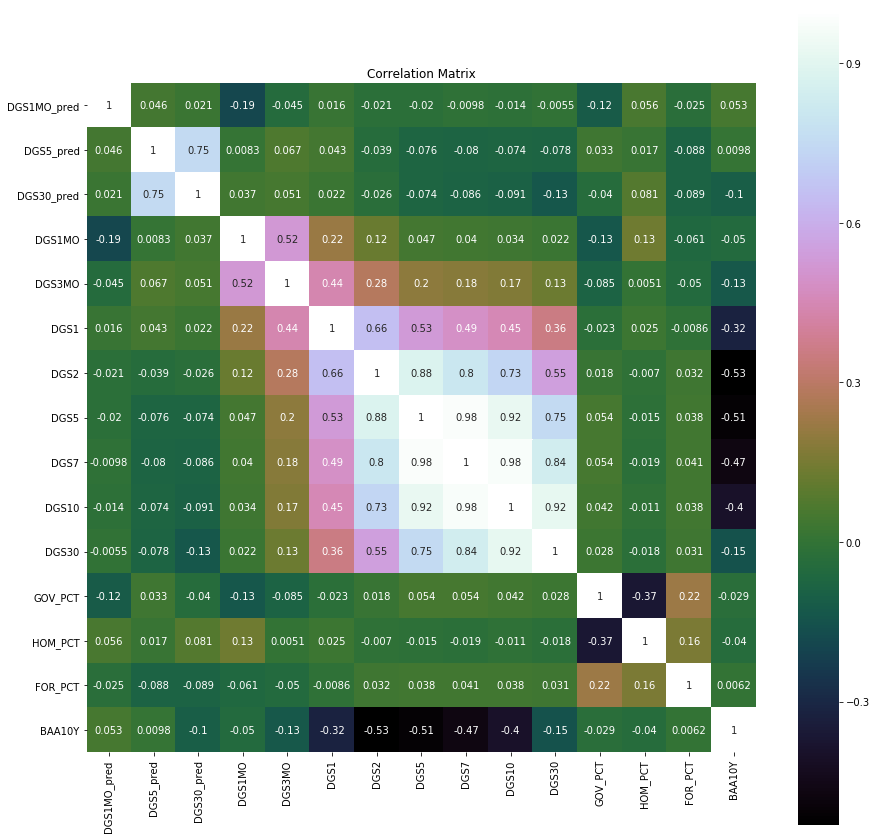

In [9]:
# correlation
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Form the correlation Plot, we see that the 1 month and the 30 year yield data points are negatively autocorrelated. The 5 year yield also seems toe be negativly correlated with the changes in foreign goverment purchases.

<Figure size 1080x1080 with 0 Axes>

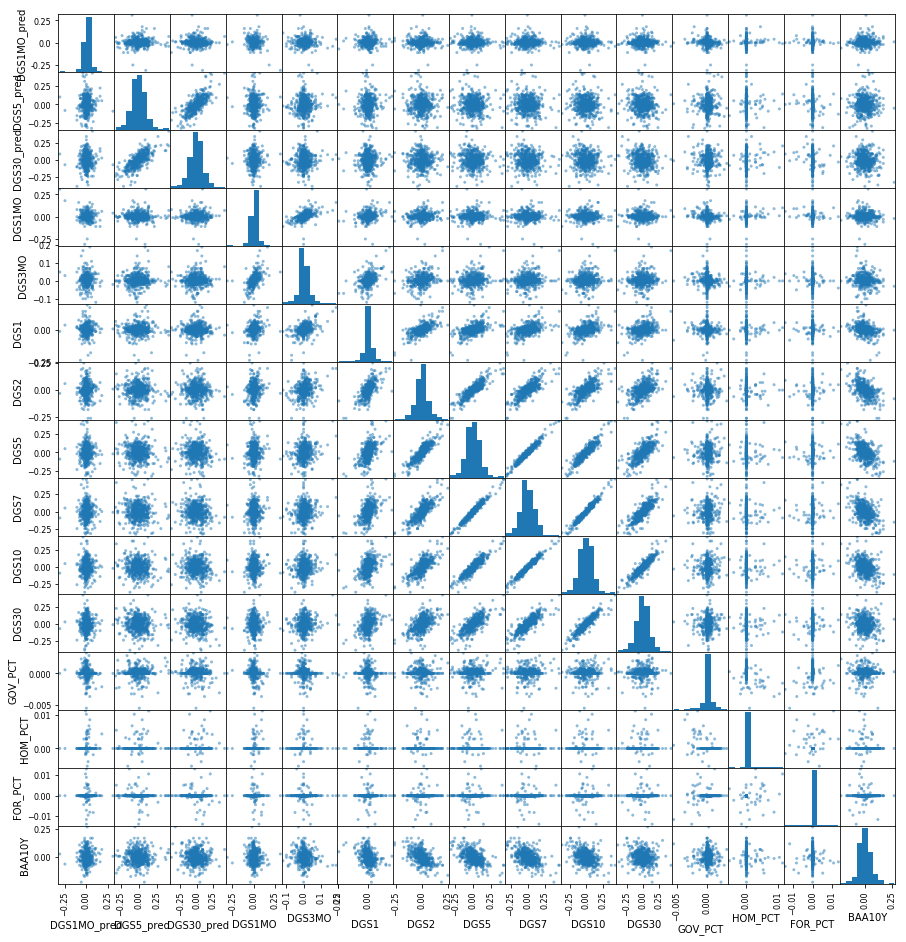

In [10]:
# Scatterplot Matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(15,16))
pyplot.show()

### Seasonal Decomposition

#### 1 Month

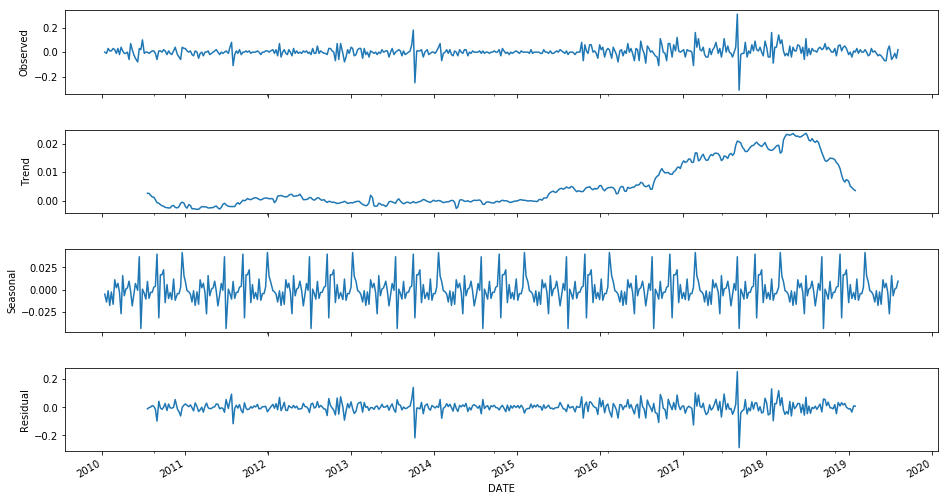

In [11]:
temp_Y = dataset['DGS1MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 5 Year

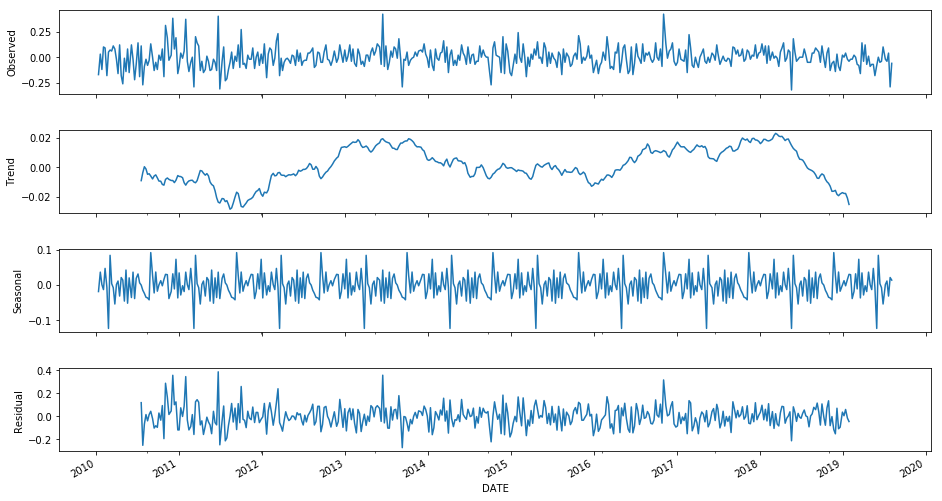

In [12]:
temp_Y = dataset['DGS5_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 30 Year

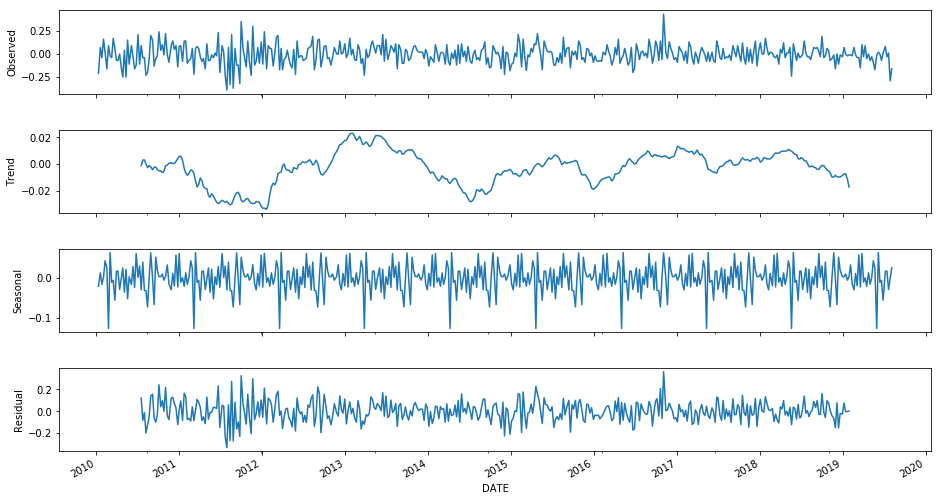

In [14]:
temp_Y = dataset['DGS30_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Around Q1 2018, we observe a trend decrease in the 1 Month, 5 year and 30 year. However, the trend is most pronounced in the 1 Month series.

#### Auto Correlation

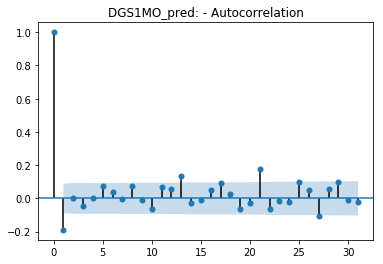

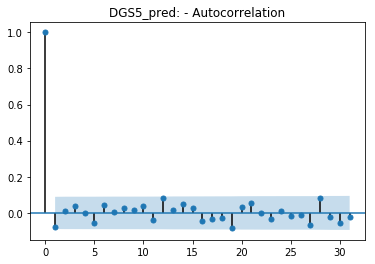

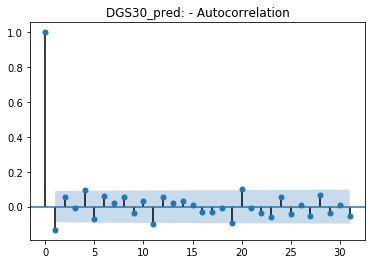

In [15]:
for col in Y.columns:
    temp_Y = dataset[col]
    plot_acf(temp_Y, lags=31)
    pyplot.title('{0}: - Autocorrelation'.format(col))
    pyplot.show()

### Univariate feature selection

In [17]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10,'Score'))  #print 10 best features
    print('--------------')

DGS1MO_pred
      Specs   Score
0    DGS1MO  18.017
8   GOV_PCT   6.626
9   HOM_PCT   1.516
11   BAA10Y   1.347
1    DGS3MO   0.999
10  FOR_PCT   0.308
3      DGS2   0.212
4      DGS5   0.186
2      DGS1   0.126
6     DGS10   0.096
--------------
DGS5_pred
      Specs  Score
10  FOR_PCT  3.768
5      DGS7  3.125
7     DGS30  2.971
4      DGS5  2.813
6     DGS10  2.623
1    DGS3MO  2.206
2      DGS1  0.892
3      DGS2  0.726
8   GOV_PCT  0.529
9   HOM_PCT  0.132
--------------
DGS30_pred
      Specs  Score
7     DGS30  8.869
11   BAA10Y  5.189
6     DGS10  4.017
10  FOR_PCT  3.814
5      DGS7  3.593
9   HOM_PCT  3.192
4      DGS5  2.680
1    DGS3MO  1.249
8   GOV_PCT  0.777
0    DGS1MO  0.660
--------------


As expected, based on the univariate feature selection, the 1 Month and the 30 year are most dependent on the previous changes. However, the 5 year seems to be most influenced by the changes in % of debt held by foreign goverments.

### Training/Test Split 

In [20]:

# split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)


We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [21]:
# test options for regression
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

In [22]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [23]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.007394289155407139 
Std CV Error: (0.0015209548869453738) 
Training Error:
DGS1MO_pred    0.002
DGS5_pred      0.009
DGS30_pred     0.009
dtype: float64 
Test Error:
DGS1MO_pred    0.001
DGS5_pred      0.014
DGS30_pred     0.014
dtype: float64
----------
LASSO: 
Average CV error: 0.0071619185266587546 
Std CV Error: (0.001498529694947503) 
Training Error:
DGS1MO_pred    0.002
DGS5_pred      0.010
DGS30_pred     0.010
dtype: float64 
Test Error:
DGS1MO_pred    0.002
DGS5_pred      0.014
DGS30_pred     0.015
dtype: float64
----------
EN: 
Average CV error: 0.0071619185266587546 
Std CV Error: (0.001498529694947503) 
Training Error:
DGS1MO_pred    0.002
DGS5_pred      0.010
DGS30_pred     0.010
dtype: float64 
Test Error:
DGS1MO_pred    0.002
DGS5_pred      0.014
DGS30_pred     0.015
dtype: float64
----------
KNN: 
Average CV error: 0.007927665587044535 
Std CV Error: (0.0016999265396161333) 
Training Error:
DGS1MO_pred    0.001
DGS5_pred      0.007
DGS30_pred    

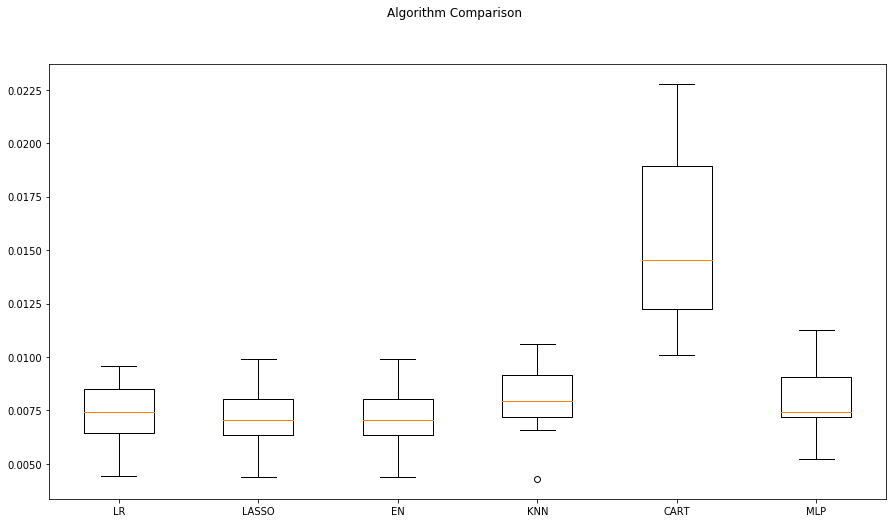

In [24]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

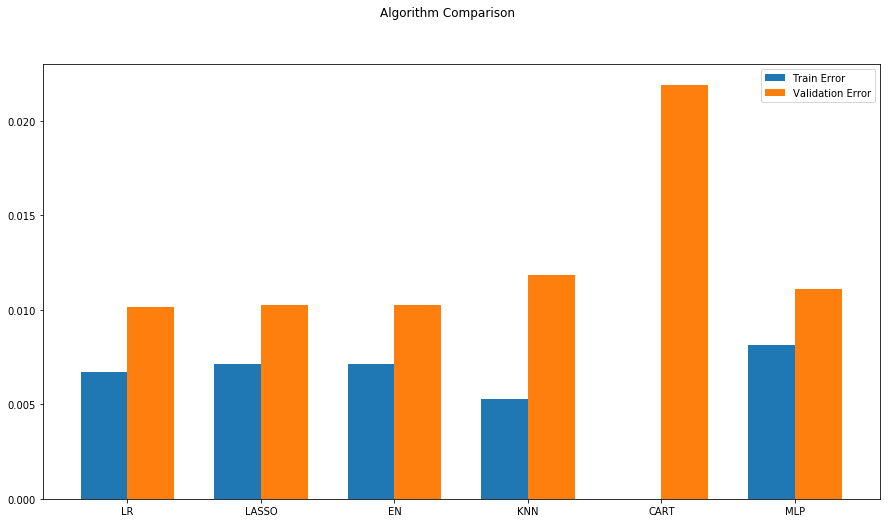

In [25]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

### Predictions - 5 Year - Linear Regression

In [32]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

model = LinearRegression()
res = model.fit(X_train, Y_train)
Y_pred = pd.DataFrame(res.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)


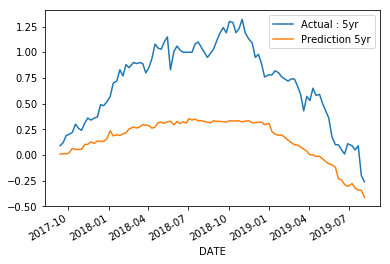

In [33]:
pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction 5yr': Y_pred.loc[:, 'DGS5_pred']}).cumsum().plot()

#### Linear Regression summary using Stats Models

In [40]:
Y_ols = Y_train.loc[:, 'DGS5_pred']
X_ols = X_train.loc[:, ['FOR_PCT', 'DGS5', 'DGS3MO']]

X_ols = sm.add_constant(X_ols)
model = sm.OLS(Y_ols,X_ols)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DGS5_pred   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.686
Date:                Sun, 18 Aug 2019   Prob (F-statistic):             0.0463
Time:                        13:23:31   Log-Likelihood:                 319.46
No. Observations:                 387   AIC:                            -630.9
Df Residuals:                     383   BIC:                            -615.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.005     -0.542      0.588      -0.014       0.008
FOR_PCT       -5.3302      3.427     -1.555      0.121     -12.068       1.408
DGS5          -0.0930      0.051     -1.811      0.071      -0.194       0.008
DGS3MO         0.3035      0.195      1.557      0.120      -0.080       0.687
==============================================================================
Omnibus:                       34.673   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.379
Skew:                           0.510   Prob(JB):                     8.60e-16
Kurtosis:                       4.807   Cond. No.                         633.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Summary

We Observe that yield curve prediction is almost as challenging as prediction changes in stock prices. Most 5 Day changes in the yield curve are autocorrelated suggesting a mean reversion strategy might be advantageous. We also observed that there is a statistically weak relationship between the changes in the Debt held by foreign governments and the changes in the 5 year yield.